# Training and Testing RR and NN decoders across multiple years

In this notebook, we compare the performance of a day-0 decoder tested successively on multiple days, across the course of almost 3 years, to the performance of decoders trained within a day.

In [109]:
import os
import sys
import pdb
from copy import deepcopy
# sys.path.append('/Users/yixuan/Documents/GitHub/pybmi')
sys.path.append('C:\Repos\pybmi')
from pybmi.utils.ZTools import ZStructTranslator,zarray
from pybmi.utils import ZTools, TrainingUtils
from pybmi.decoders import NNDecoders
from pybmi.offline import TrainingOffline
from pybmi.utils.AnalysisTools import adjustfeats

import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy import stats
import numpy as np
import pandas as pd
import pickle 

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from collections import defaultdict
import datetime
import pdb

In [3]:
# Define function for splitting training and testing data
def dataPrep(feats, hist, numChans=96):
    '''
    Get test and training data splits from a single session - also prep 2D and 3D versions

    '''
    TrialIndex = feats['TrialIndex']
    
    if len(TrialIndex) > 300:
        test_len = np.min((len(TrialIndex)-1, 399))

        neural_training = feats['NeuralFeature'][:TrialIndex[300]]
        neural_testing = feats['NeuralFeature'][TrialIndex[300]:TrialIndex[test_len]]

        finger_training = feats['FingerAnglesTIMRL'][:TrialIndex[300]]
        finger_testing = feats['FingerAnglesTIMRL'][TrialIndex[300]:TrialIndex[test_len]]

    else:
        pdb.set_trace()
        raise Exception('not enough trials')

        
    neural_training, finger_training = adjustfeats(neural_training, finger_training, hist = hist, out2d = True)
    neural_testing, finger_testing = adjustfeats(neural_testing, finger_testing, hist = hist, out2d = True)
    
    neural_training3D = neural_training.reshape(len(neural_training), numChans, -1)
    neural_testing3D = neural_testing.reshape(len(neural_testing), numChans, -1)

    neural_testing = np.concatenate((neural_testing, np.ones((len(neural_testing), 1))), axis=1) # add a column of ones for RR
    neural_training = np.concatenate((neural_training, np.ones((len(neural_training), 1))), axis=1) # add a column of ones for RR

    return neural_training, neural_testing, neural_training3D, neural_testing3D, finger_training, finger_testing

In [4]:
def trainNetwork(neu, vel):
    device = torch.device('cuda:0')
    dtype = torch.float
    
    neu = torch.from_numpy(neu).to(device, dtype)
    vel = torch.from_numpy(vel).to(device, dtype)

    #create pytorch datasets and then dataloaders
    ds = TensorDataset(neu, vel)

    #since we know how long we're training, val dataset can just be the same as training
    dl = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)
    dl2 = DataLoader(ds, batch_size=len(ds), shuffle=False, drop_last=True)
    
    #Model Instance and architecture
    in_size = neu.shape[1]
    layer_size = 256
    ConvSize = 5
    ConvSizeOut = 16
    num_states = 4

    model = NNDecoders.FC4L256Np05_CNN1L16N_SBP(in_size, layer_size, ConvSize, ConvSizeOut, num_states).to(device)

    #training hyperparams as determined previously (not finalized yet)
    epochs = 10
    learning_rate = 1e-4
    weight_decay = 1e-2
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    #run fit function (model is trained here)
    loss_h, vloss_h = TrainingOffline.fit(epochs, model, opt, dl, dl2, print_every=1, print_results=True)

    # generate scaler (need diff organized Dataset since scaler is online code)
    ds_scale = TrainingUtils.BasicDataset(neu, vel)
    dl_scale = DataLoader(ds_scale, batch_size=len(ds_scale), shuffle=True)
    scaler = TrainingUtils.generate_output_scaler(model, dl_scale, num_outputs=num_states)
    model = model.cpu()
    
    return model, scaler, loss_h, vloss_h

In [183]:
# source_folder = "/Volumes/share/Student Folders/Bianca_Wang/"
source_folder = 'Z:\Student Folders\Bianca_Wang'
data_folder = os.path.join(source_folder,'updated_retrieved')

results_dict = {
    'date':[],
    'day':[],
    'decoder':[],
    'targStyle':[],
    'day_0':[]
}

for i in range(4):
    results_dict[f'r2_{i}'] = []
    results_dict[f'corr_{i}'] = []
    results_dict[f'mse_{i}'] = []

# dates_to_exclude = ['2020-08-31', '2021-05-19', '2022-05-31', '2022-06-23', '2022-10-21', '2021-02-02', 
#                     '2021-08-17', '2021-03-10']

dates_to_exclude = ['2023-09-26']

for file_name in os.listdir(data_folder):

    pdb.set_trace()n
    file = os.path.join(data_folder, file_name)
    with open(file, 'rb') as f:
        feats = pickle.load(f)
        print("Data loaded")
    
    if feats["Date"] in dates_to_exclude:
        continue

    neural_train, neural_test, neural_train3D, neural_test3D, finger_train, finger_test = dataPrep(feats, 4)
    
    model_output = os.path.join(source_folder, 'models',f"{feats['Date']}_models.pkl")
    
    train_models = True
    if train_models:
        # regression
        reg = linear_model.Ridge(alpha = 0.01)

        # training
        reg.fit(neural_train, finger_train)
        nn_model, scaler, train_loss, val_loss = trainNetwork(neural_train3D, finger_train)

        with open(model_output, 'wb') as f:
            pickle.dump((reg, nn_model, scaler), f)

    else:
        with open(model_output, 'rb') as f:
            reg, nn_model, scaler = pickle.load(f)
    
    day0_output = os.path.join(source_folder, 'models', f"models_day0_{int(feats['Target Style'])}.pkl")
    
    #check if : a) this is a day0, b) should we train a model
    if firstone29 and (feats['Target Style'] == 29.0):
        firstone29 = False
        if train_models:
            reg0 = linear_model.Ridge(alpha=0.01)
            reg0.fit(neural_train, finger_train)
            nn_model0, scaler0, tl, vl = trainNetwork(neural_train3D, finger_train)
            with open(day0_output, 'wb') as f:
                pickle.dump((reg0, nn_model0, scaler0), f)
    
    if firstone34 and (feats['Target Style'] == 34.0):
        firstone34 = False
        if train_models:
            reg0 = linear_model.Ridge(alpha=0.01)
            reg0.fit(neural_train, finger_train)
            nn_model0, scaler0, tl, vl = trainNetwork(neural_train3D, finger_train)
            with open(day0_output, 'wb') as f:
                pickle.dump((reg0, nn_model0, scaler0), f)

    # load the day 0 model
    with open(day0_output, 'rb') as f:
        reg0, nn_model0, scaler0 = pickle.load(f)
    
    # get predictions on the test dataset
    rr_prediction = reg.predict(neural_test)
    nn_model.eval()
    nn_prediction = scaler.scale(nn_model(torch.from_numpy(neural_test3D).to(torch.float))).cpu().detach().numpy()

    rr_prediction0 = reg0.predict(neural_test)
    nn_model0.eval()
    nn_prediction0 = scaler0.scale(nn_model0(torch.from_numpy(neural_test3D).to(torch.float))).cpu().detach().numpy()

    # get metrics for both
    preds = (rr_prediction, nn_prediction)
    preds0 = (rr_prediction0, nn_prediction0)
    labels = ('rr', 'nn')
    for i in range(2):
        r2 = r2_score(finger_test, preds[i], multioutput = 'raw_values')
        r2_0 = r2_score(finger_test, preds0[i], multioutput = 'raw_values')

        cc = np.diag(np.corrcoef(finger_test, preds[i], rowvar = False)[0:4, 4:8])
        cc_0 = np.diag(np.corrcoef(finger_test, preds0[i], rowvar = False)[0:4, 4:8])
            
        mse = mean_squared_error(finger_test, preds[i], multioutput='raw_values')
        mse_0 = mean_squared_error(finger_test, preds0[i], multioutput='raw_values')
        
        results_dict['date'].append(feats['Date'])
        results_dict['decoder'].append(labels[i])
        results_dict['targStyle'].append(feats['Target Style'])
        results_dict['day_0'].append(False)
        for j in range(4):
            results_dict[f'r2_{j}'].append(r2[j])
            results_dict[f'corr_{j}'].append(cc[j])
            results_dict[f'mse_{j}'].append(mse[j])

        results_dict['date'].append(feats['Date'])
        results_dict['decoder'].append(labels[i])
        results_dict['targStyle'].append(feats['Target Style'])
        results_dict['day_0'].append(True)
        for j in range(4):
            results_dict[f'r2_{j}'].append(r2_0[j])
            results_dict[f'corr_{j}'].append(cc_0[j])
            results_dict[f'mse_{j}'].append(mse_0[j])

day0 = datetime.datetime.strptime(results_dict['date'][0], '%Y-%m-%d')
results_dict['day'] = [(datetime.datetime.strptime(day, '%Y-%m-%d') - day0).days for day in results_dict['date']]

> c:\users\hisham\appdata\local\temp\ipykernel_20440\4127777687.py(26)<module>()



> c:\users\hisham\appdata\local\temp\ipykernel_20440\4127777687.py(27)<module>()

> c:\users\hisham\appdata\local\temp\ipykernel_20440\4127777687.py(28)<module>()

> c:\users\hisham\appdata\local\temp\ipykernel_20440\4127777687.py(29)<module>()

Data loaded
> c:\users\hisham\appdata\local\temp\ipykernel_20440\4127777687.py(31)<module>()

> c:\users\hisham\appdata\local\temp\ipykernel_20440\4127777687.py(34)<module>()

{'Date': '2020-01-27', 'Run': 'Run-003', 'Target Style': 34.0, 'TrialNumber': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  

In [161]:
results_df = pd.DataFrame(results_dict)

# change dataframe so it works more easily with lmplot
d1 = results_df.set_index(['date','day','decoder','targStyle','day_0']).stack().reset_index()
d1[['metric','out_var']] = d1['level_5'].str.split('_', expand=True)
d1 = d1.drop('level_5',axis=1)
d1 = d1.rename(columns = {0: 'value'})
results_df = pd.pivot_table(d1, index=['date','day','decoder','targStyle','day_0','out_var'], columns=['metric']).reset_index()
results_df.columns = ['date','day','decoder','targStyle','day_0','out_var','corr','mse','r2']

with open(os.path.join(source_folder,'results.pkl'),'wb') as f:
    pickle.dump(results_df, f)

In [162]:
with open(os.path.join(source_folder,'results.pkl'),'rb') as f:
    results_df = pickle.load(f)

r2 is all over the place, need to see how to work with it, corr seems to show pretty clear info

In [207]:
def performance_over_time(data):
    # first look at the performance over the whole time period
    lm = sns.lmplot(data=data, x='day', y='corr', col='out_var',row='decoder',hue='day_0')
    axs = lm.axes
    for ax in axs.flatten():
        ax.set(ylim = (-1,1))

    

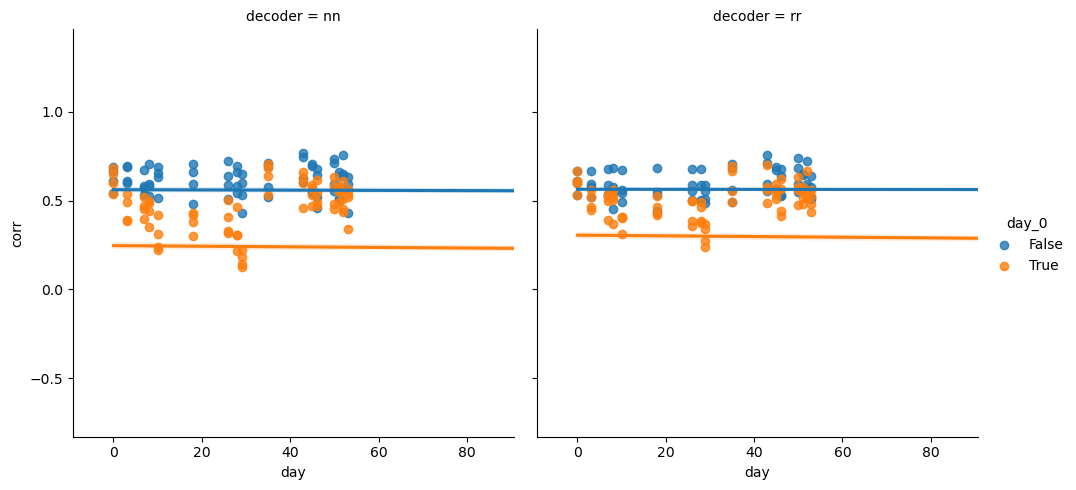

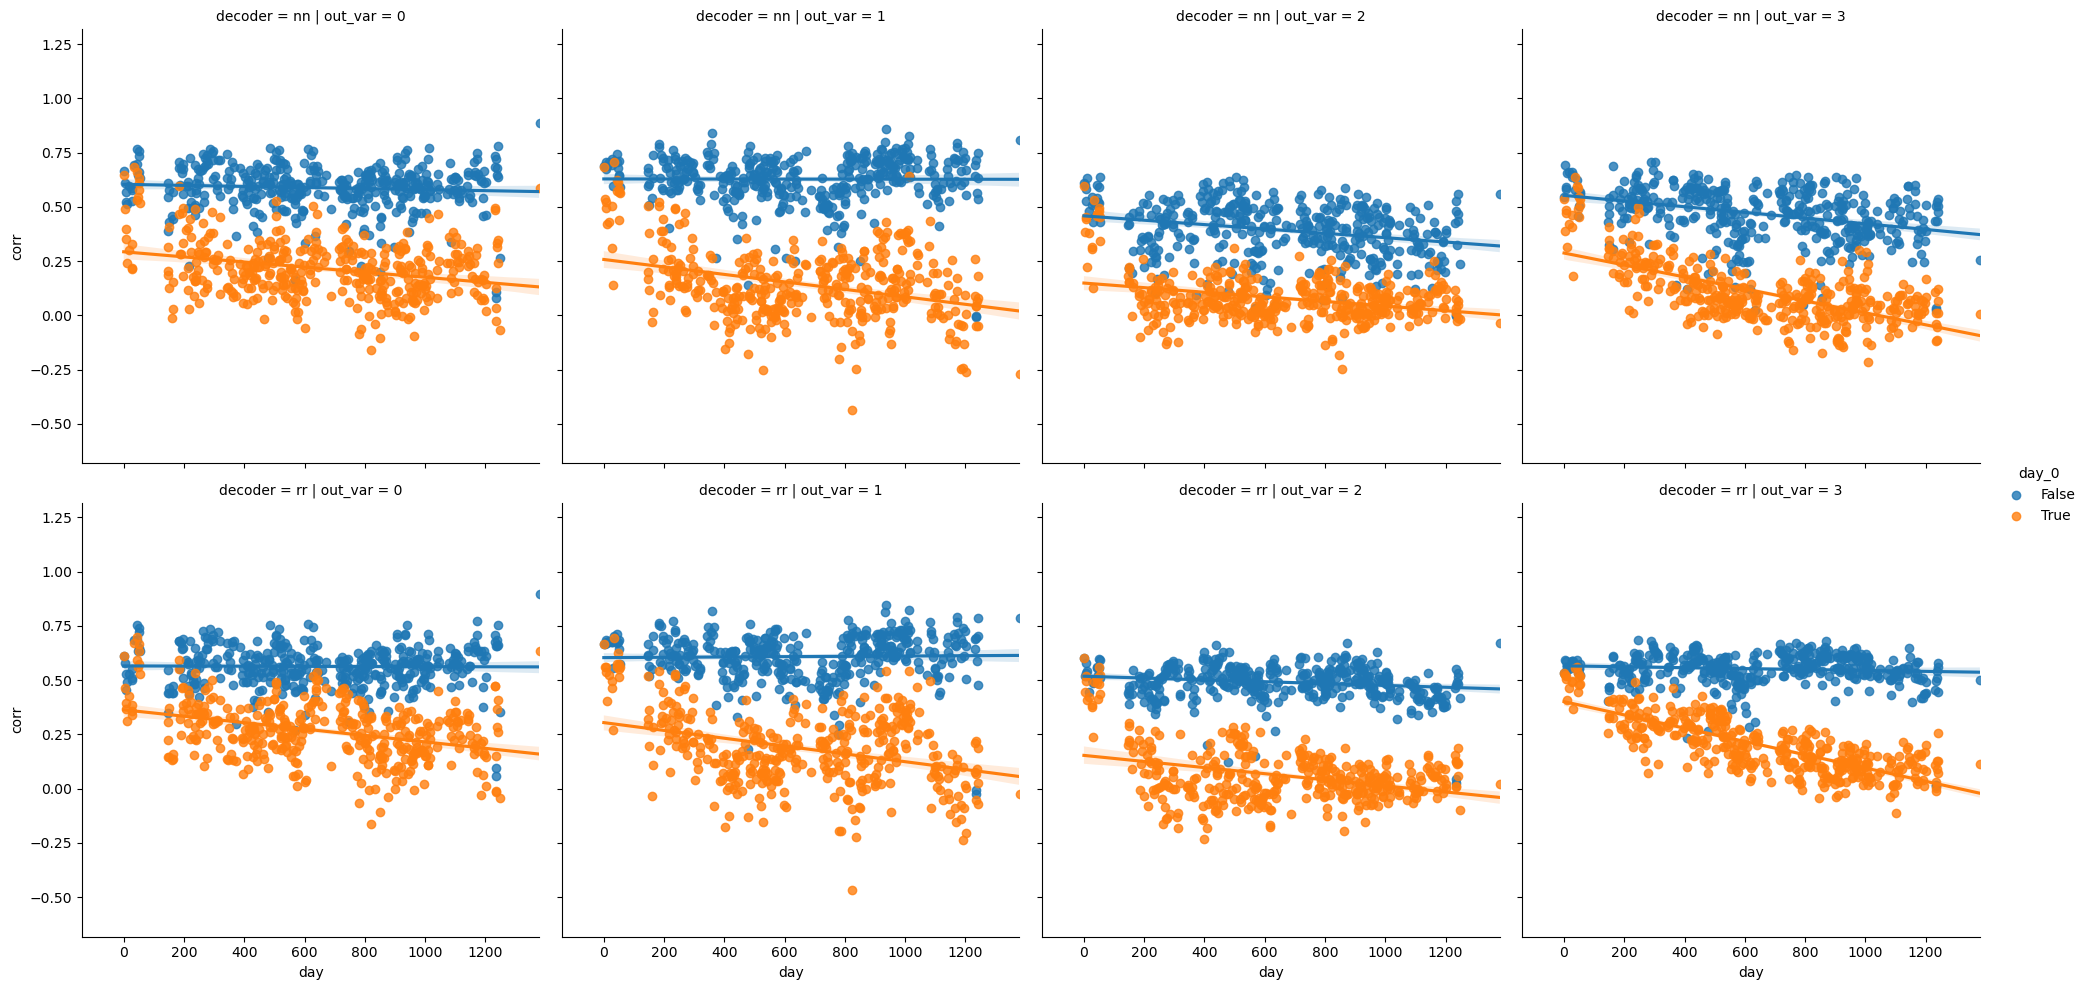

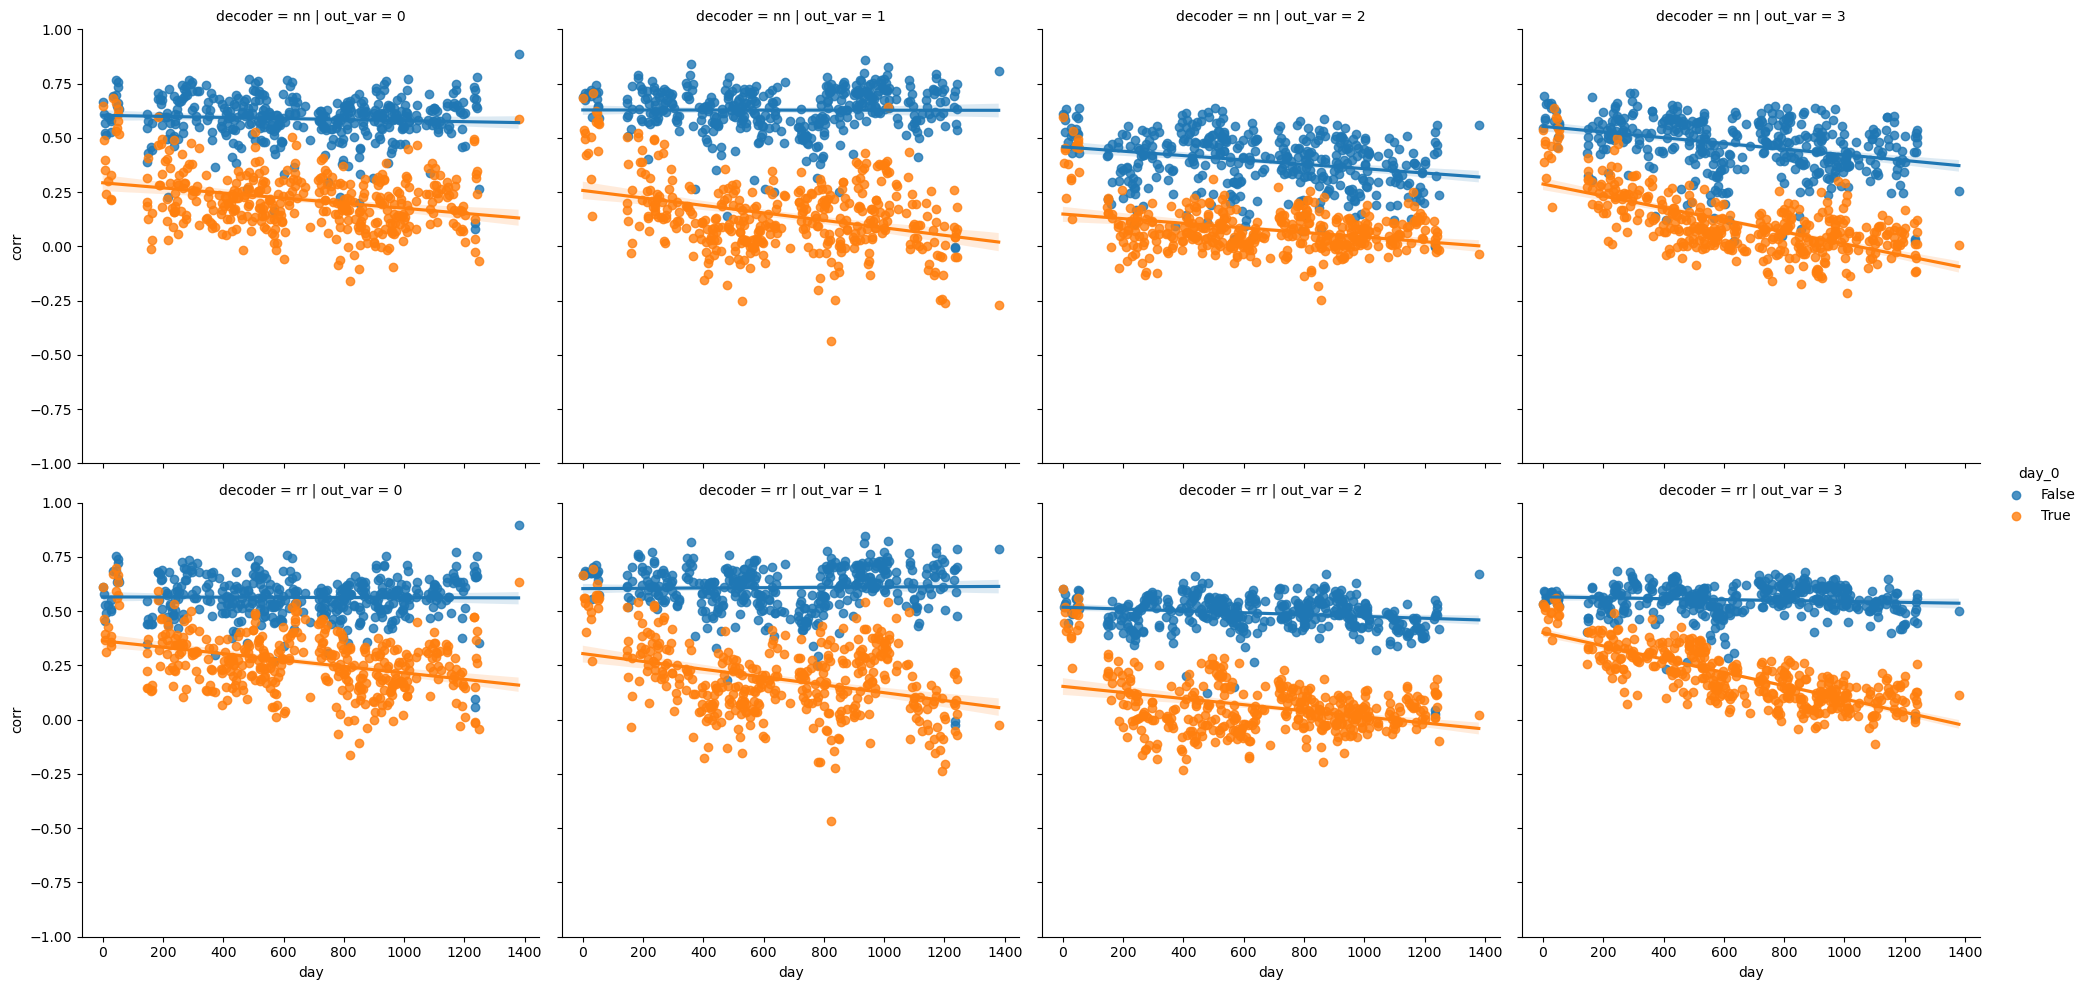

In [210]:
%matplotlib inline

plt.ion()
performance_over_time(results_df_re)


In [209]:
#just the first few examples


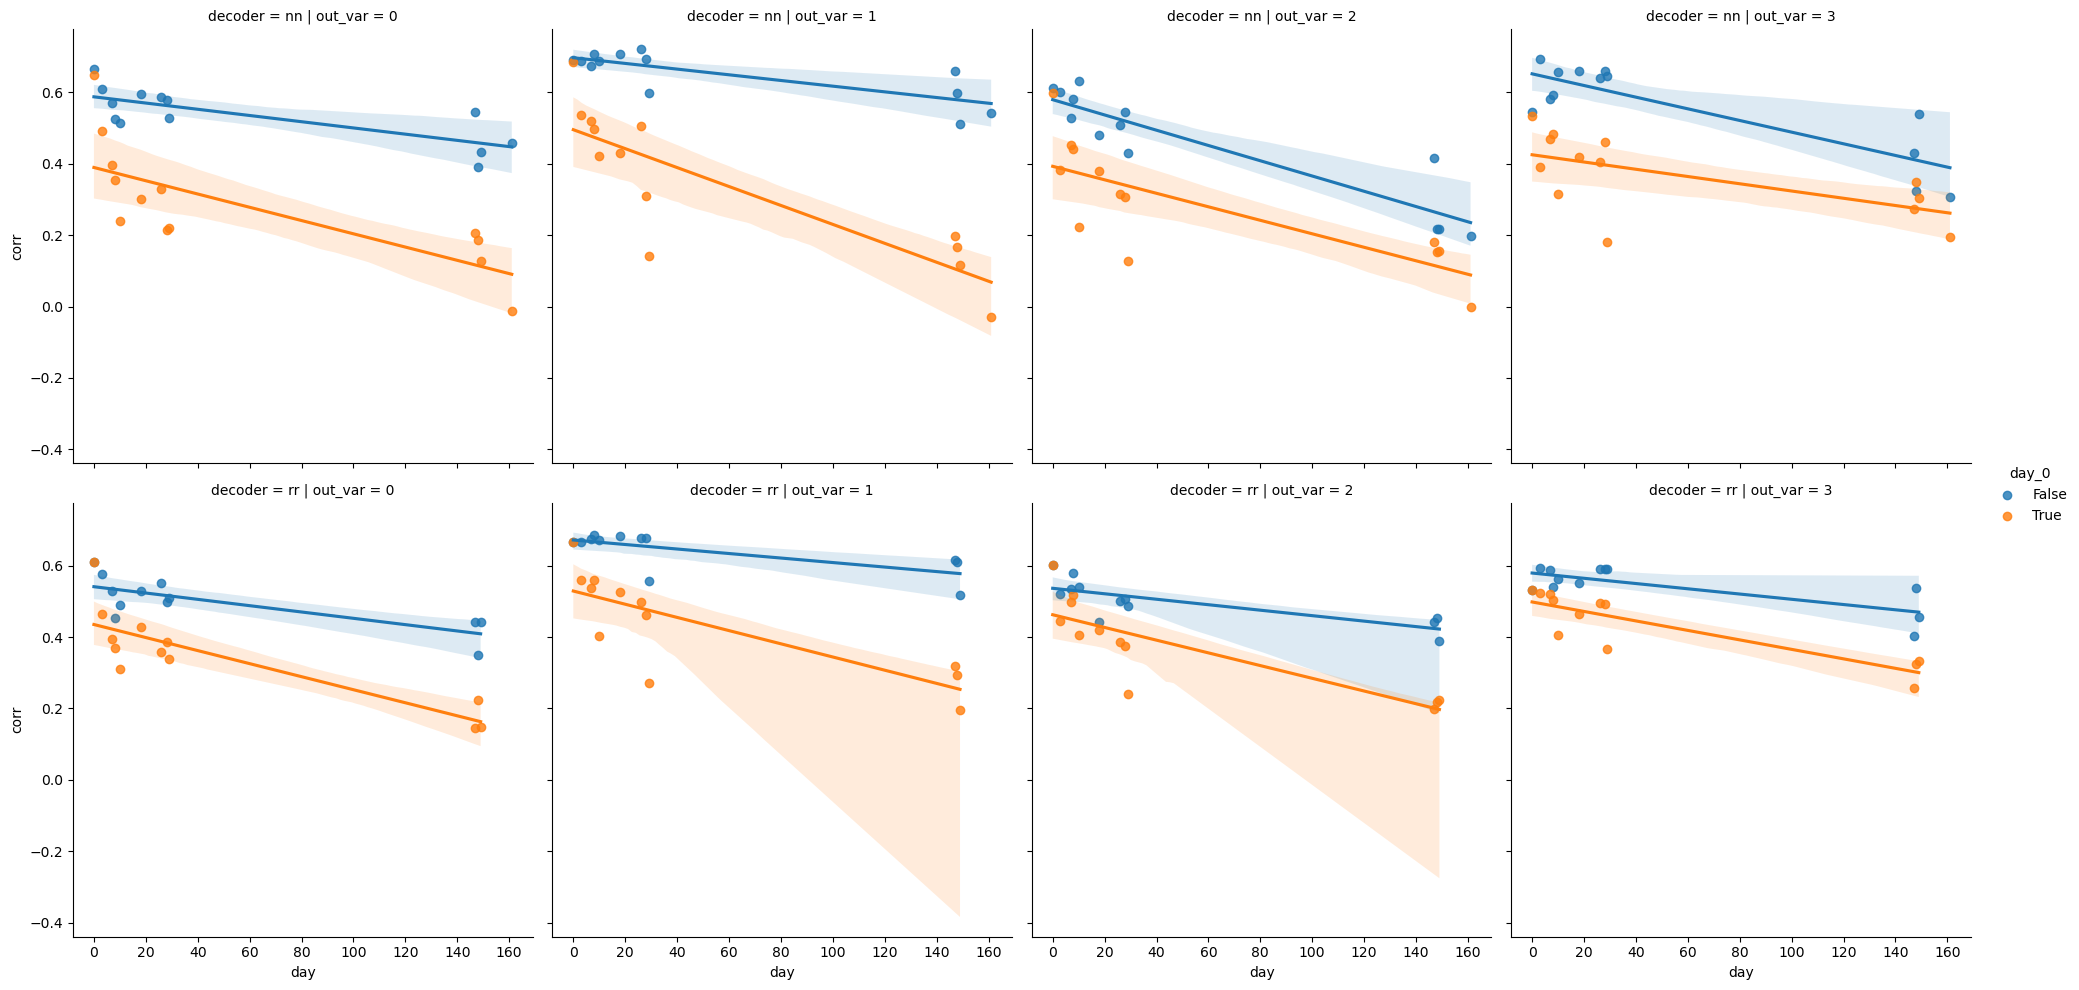

In [150]:
sns.lmplot(data=df_34[0:200], x='day', y='corr',col='out_var',row='decoder',hue='day_0')

In [ ]:
# plotting MSE for TS 29
plt.figure(figsize=(10, 8))

for index, dof in zip([1, 2, 3, 4], [0, 1, 2, 3]):
    plt.subplot(2, 2, index)
    plotting_r(regression29, "MSE", dof, 0, 1)

plt.suptitle("Regression for TS29, MSE")

plt.subplots_adjust(wspace = 0.75) 
plt.subplots_adjust(hspace = 0.4) 

plt.show()

In [ ]:
def find_outliers(TS, dof):
    mean = np.mean(TS['r^2'][:,dof])
    sd = np.std(TS['r^2'][:,dof])
    threshold = 3 * sd
    outliers_dates = []

    for i, num in enumerate(TS['r^2'][:, dof]):
        if abs(num - mean) > threshold:
            outliers_dates.append(TS['Date'][i])

    return outliers_dates

for i in [0, 1, 2, 3]:
    print(find_outliers(regression29, i))
    print(find_outliers(regression34, i))

z.keys()

In [ ]:
# plotting Correlation for TS 29

plt.figure(figsize=(10, 8))

for index, dof in zip([1, 2, 3, 4], [0, 1, 2, 3]):
    plt.subplot(2, 2, index)
    plotting_r(regression29, "Correlation", dof, -1, 1)

plt.suptitle("Regression for TS29, correlation")

plt.subplots_adjust(wspace = 0.75) 
plt.subplots_adjust(hspace = 0.4) 

plt.show()

In [ ]:
# plotting correlation for TS 34
plt.figure(figsize=(10, 8))

for index, dof in zip([1, 2, 3, 4], [0, 1, 2, 3]):
    plt.subplot(2, 2, index)
    plotting_r(regression34, "Correlation", dof, -0.5, 0.6)

plt.suptitle("Regression for TS34, Correlation")

plt.subplots_adjust(wspace = 0.75) 
plt.subplots_adjust(hspace = 0.4) 

plt.show()

In [ ]:
# plotting MSE for TS 34
plt.figure(figsize=(10, 8))

for index, dof in zip([1, 2, 3, 4], [0, 1, 2, 3]):
    plt.subplot(2, 2, index)
    plotting_r(regression34, "MSE", dof, 0, 0.1)

plt.suptitle("Regression for TS34, MSE")

plt.subplots_adjust(wspace = 0.75) 
plt.subplots_adjust(hspace = 0.4) 

plt.show()

In [ ]:
# plotting r2 for TS 34
plt.figure(figsize=(10, 8))

for index, dof in zip([1, 2, 3, 4], [0, 1, 2, 3]):
    plt.subplot(2, 2, index)
    plotting_r(regression34, "r^2", dof, -50, 1)

plt.suptitle("Regression for TS34, r^2")

plt.subplots_adjust(wspace = 0.75) 
plt.subplots_adjust(hspace = 0.4) 

plt.show()

In [ ]:
negative_days_TS29 ={
    'Date_r^2_0': [],
    'negative_r^2_0': [],
    'Date_MSE_0': [],
    'negative_MSE_0': []
}

negative_days_TS34 ={
    'Date_r^2_0': [],
    'negative_r^2_0': [],
    'Date_MSE_0': [],
    'negative_MSE_0': []
}

def finding_negative_days(TS, dictionary):
    
    for date, r2 in zip(TS["Date"], TS["r^2_0"]):
        if any(dof < 0 for dof in r2):
            dictionary['Date_r^2_0'].append(date)
            dictionary['negative_r^2_0'].append(r2)
        
    for date, MSE in zip(TS["Date"], TS["MSE_0"]):
        if any(dof < 0 for dof in MSE):
            dictionary['Date_MSE_0'].append(date)
            dictionary['negative_MSE_0'].append(MSE)

In [ ]:
finding_negative_days(regression29, negative_days_TS29)
finding_negative_days(regression34, negative_days_TS34)

In [ ]:
plt.hist(regression29['r^2'], bins = 30)

In [184]:
file = os.path.join(data_folder, file_name)
with open(file, 'rb') as f:
    feats = pickle.load(f)
    print("Data loaded")

Data loaded
